<a href="https://colab.research.google.com/github/PGrabinski/ReinforcementLearning/blob/master/Burton_Sutton_ch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# K-bandit with $\epsilon-$greedy learning

In [0]:
class K_bandit:
  def __init__(self, k, stationary=True, initial_values=None, noise_mean=0., noise_devation=0.01, automatic_update=True):
    self.stationary = stationary
    self.k = k
    self.noise_deviation = 1
    self.noise_mean = 0.
    self.automatic_update = automatic_update
    if self.stationary:
      self.q_true = np.random.normal(loc=0., scale=1., size=(k,))
    else:
      if initial_values is None:
        self.q_true = np.zeros(shape=(k,))
      elif initial_values.shape == (k,):
        self.q_true = initial_values
        
  def update_rewards(self):
    if not self.stationary:
      self.q_true += np.random.normal(loc=self.noise_mean, scale=self.noise_deviation, size=self.q_true.shape)      
        
  def __call__(self, action):
    reward = self.q_true[action]
    if self.automatic_update:
      self.update_rewards()
    return reward
  
  def max_reward(self):
    true_max_reward = np.amax(self.q_true)
    true_max_indices = np.argwhere(self.q_true == true_max_reward)
    true_action_id = true_max_indices[np.random.randint(low=0, high=true_max_indices.shape[0])]
    return true_action_id

In [0]:
class epsilon_greedy:
  '''
  epsilon-greedy with constant step alpha
  with epsilon=0 it represents the greedy strategy
  with high initial values it can represent the greed optimistic initial values strategy 
  '''
  def __init__(self, k, bandit, alpha=0.1, epsilon=0.1, initial_values=None):
    self.k = k
    self.bandit = bandit
    
    if initial_values is None:
      self.q_estimate = np.zeros(shape=(k,))
    else:
      self.q_estimate = initial_values
    self.alpha = alpha
    self.epsilon = epsilon
    
    self.step = None
    self.total_reward = 0
    self.avg_reward_history = []
    self.total_right_decisions = 0
    self.avg_right_decisions_history = []
    
  def make_step(self, max_action=None, true_values=None):
    if self.step is None:
      self.step = 1
    action_id = None
    max_reward = np.amax(self.q_estimate)
    max_indices = np.argwhere(self.q_estimate == max_reward)
    if max_action is None:
      true_action_id = self.bandit.max_reward()
    else:
      tru_action_id = max_action
    if np.random.random() <= self.epsilon:
      action_id = np.random.randint(low=0, high=self.k)
      if action_id == true_action_id:
        self.total_right_decisions += 1
    else:
      action_id = max_indices[np.random.randint(low=0, high=max_indices.shape[0])]
      if action_id == true_action_id:
        self.total_right_decisions += 1
    if true_values is None:
      current_reward = self.bandit(action_id)
    else:
      current_reward = true_values[action_id]
    self.q_estimate[action_id] = (1 - self.alpha) * self.q_estimate[action_id] + self.alpha * current_reward
    self.total_reward += current_reward      
    self.step += 1
    self.avg_reward_history.append(self.total_reward/self.step)
    self.avg_right_decisions_history.append(self.total_right_decisions/self.step)
  

# Exercise 2.5

In [0]:
bandit = K_bandit(k=10, stationary=False, initial_values=None)

In [0]:
agent = epsilon_greedy(k=10, bandit=bandit, alpha=0.1, epsilon=0.1, initial_values=None)

In [0]:
for _ in range(200000):
  agent.make_step()

(0, 1)

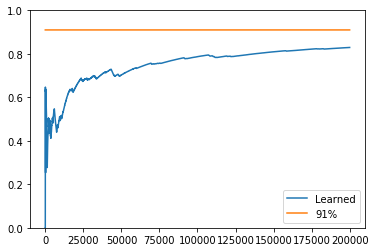

In [7]:
X = np.arange(len(agent.avg_right_decisions_history))
plt.plot(X, np.array(agent.avg_right_decisions_history), label='Learned')
plt.plot(X, 0.91*np.ones(shape=X.shape), label='91%')
plt.legend()
plt.ylim((0,1))

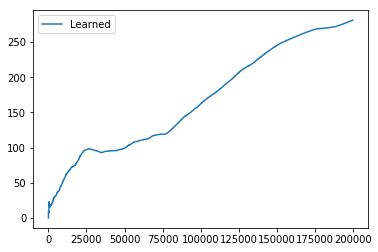

In [8]:
X2 = np.arange(len(agent.avg_reward_history))
plt.plot(X2, np.array(agent.avg_reward_history), label='Learned')
plt.legend()

In [9]:
bandit.q_true

array([ 375.86344135,  363.98968458,  296.10687429, -342.36715909,
        -37.88909394, -369.53797782, -298.74177433,  113.10110408,
        480.76348285, -138.17864348])

In [10]:
agent.q_estimate

array([ 400.81386127,  359.67852906,  290.51335428, -348.01796987,
        -79.30320159, -373.44591807, -303.19164327,   92.81502797,
        482.13924259, -134.88352758])

In [11]:
bandit.q_true - agent.q_estimate

array([-24.95041992,   4.31115552,   5.59352   ,   5.65081077,
        41.41410766,   3.90794025,   4.44986894,  20.28607611,
        -1.37575974,  -3.2951159 ])

In [12]:
(bandit.q_true - agent.q_estimate) / bandit.q_true

array([-0.06638161,  0.01184417,  0.01889021, -0.01650512, -1.09303505,
       -0.01057521, -0.01489537,  0.17936232, -0.00286161,  0.02384678])

# Exercise 2.11

In [35]:
length = 200000
half_length = int(length*0.5)
N = 10
resolution = 5
alphas = [2**(1/resolution*i-7) for i in range(0, 9*resolution+1)]
performances = np.zeros(shape=(len(alphas),))
for _ in range(N):
  bandit = K_bandit(k=10, stationary=False, initial_values=None, automatic_update=False)
  for id, alpha in enumerate(alphas):
    agent = epsilon_greedy(k=10, bandit=bandit, alpha=alpha, epsilon=0.1, initial_values=None)
    for _ in range(length):
      agent.make_step()
      bandit.update_rewards()
    performance = (agent.avg_reward_history[-1] * length - agent.avg_reward_history[half_length] * half_length) / half_length
    performances[id] += performance
  performance = np.array(performances).mean()
performances /= N 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars


In [36]:
performances

array([ 588.84850519,  868.05299925, 1180.71897776, 1378.84775508,
       1470.9602703 , 1570.19745818, 1661.6686484 , 1815.38467454,
       1836.12146092, 1993.66889442, 2083.10258658, 2057.48728131,
       2278.55668278, 2346.26378027, 2459.44595439, 2719.77264088,
       2790.06470321, 2888.52556991, 2761.25867332, 2858.27383071,
       2983.18838795, 3009.08971346, 3172.78615261, 3318.89432257,
       3327.80806732, 3533.29612389, 3533.46646283, 3757.34141206,
       3687.60063831, 4059.33276443, 4007.36869868, 3851.12802744,
       3789.96708454, 3994.65433338, 3988.40979569, 3848.50237066,
       4073.2891078 , 4233.25915255, 4248.40436423, 4301.72687709,
       2522.05889372,  315.07588914,  321.33155924,  317.90000454,
        389.08219203,  414.55016537])

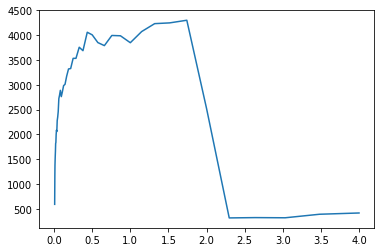

In [37]:
plt.plot(np.array(alphas), performances)
